# Expérimentation de classification des signaux de trading pour Bitcoin (BTC)

Ce notebook télécharge des données 15 minutes de la paire **BTCUSDT** depuis le site officiel [data.binance.vision](https://data.binance.vision) qui répertorie les fichiers mensuels de bougies kline pour différents actifs et timeframes【977648491801858†screenshot】.

Nous allons :
1. Télécharger et assembler les données 15 m sur 2023 et 2024.
2. Calculer plusieurs indicateurs techniques (retours, moyennes mobiles simples et exponentielles, RSI, ATR relatif, ADX et MACD).
3. Définir une cible binaire basée sur le ROI futur net de frais : acheter (1) si le rendement futur sur 24 h couvre au moins les frais (0,2 %), sinon ne pas acheter (0).
4. Diviser chronologiquement le dataset en ensemble d'entraînement, de validation et de test.
5. Entraîner un modèle **RandomForestClassifier** comme baseline.
6. Entraîner un modèle **TabPFNClassifier** (foundation model pour données tabulaires) et comparer les performances.

Les cellules ci‑dessous peuvent être exécutées dans Google Colab. Assurez‑vous d'avoir les droits Internet pour télécharger les fichiers Zip.

In [2]:
# Installation des dépendances
# `tabpfn` apporte le modèle de fondation pour données tabulaires.
# Résolution du conflit de dépendance pour 'requests'
# !pip uninstall -y requests # Désinstaller la version actuelle de requests
# !pip install requests==2.32.4 # Installer la version requise par google-colab
# !pip install -q scikit-learn pandas numpy python-dotenv ccxt # Installer les autres dépendances

In [8]:
# Import des librairies
import os
import io
import requests
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime
import ccxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# La classe TabPFNClassifier sera importée plus loin après installation
from tabpfn import TabPFNClassifier

pd.options.display.float_format = '{:.6f}'.format

In [9]:
CAPITAL_INIT=1000

## Étape 1 : Télécharger et assembler les données

Nous allons télécharger les fichiers ZIP mensuels de données kline 15 minutes pour BTCUSDT sur les années 2023 et 2024 (jusqu'à novembre 2024). Chaque fichier contient les colonnes suivantes : `open_time`, `open`, `high`, `low`, `close`, `volume` et d'autres que nous n'utiliserons pas.
Le site `data.binance.vision` fournit ces archives de manière publique ; on boucle sur les mois, télécharge chaque ZIP et concatène les DataFrames.

In [10]:
import ccxt
import time
from datetime import datetime

def fetch_ohlcv_since(symbol='BTC/USDC', timeframe='1h', start_date='2025-01-01', end_date=None):
    # Initialiser l'exchange Binance
    exchange = ccxt.binance({
        'enableRateLimit': True,  # Respecter les limites de taux
    })
    # Date de début : 1er janvier 2021
    since = int(pd.Timestamp(start_date).timestamp() * 1000)  # Convertir en timestamp en millisecondes

    print(f"Récupération des données historiques pour {symbol} avec timeframe {timeframe} entre {start_date} et {end_date}...")

    # Récupérer toutes les données historiques disponibles
    all_ohlcv = []
    limit = 1000  # Nombre maximum de bougies par requête (limite de Binance)
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    while since < int(pd.Timestamp(end_date).timestamp() * 1000):
        try:
            # Récupérer les données
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            
            if not ohlcv:
                break
            
            # Ajouter les données à la liste
            all_ohlcv.extend(ohlcv)
            
            # Mettre à jour since pour la prochaine itération (dernier timestamp + 1)
            since = ohlcv[-1][0] + 1
            
            # Afficher la progression
            print(f"Récupéré {len(all_ohlcv)} bougies... Dernière date: {datetime.fromtimestamp(ohlcv[-1][0] / 1000)}")
            
            # Si on a récupéré moins que la limite, on a atteint la fin
            if len(ohlcv) < limit:
                break
            
            # Petite pause pour respecter les limites de taux
            time.sleep(exchange.rateLimit / 1000)
            
        except Exception as e:
            print(f"Erreur lors de la récupération: {e}")
            break

    print(f"\nTotal de {len(all_ohlcv)} bougies récupérées")

    # Convertir en DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convertir le timestamp en datetime
    df['open_time'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Réorganiser les colonnes
    df = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]

    # Trier par date (du plus ancien au plus récent)
    df = df.sort_values('open_time').reset_index(drop=True)

    # Filtre sur la période
    df = df.loc[(df['open_time'] >= start_date) & (df['open_time'] <= end_date), :]

    # Supprimer les doublons éventuels
    df = df.drop_duplicates(subset=['open_time']).reset_index(drop=True)

    print(f"\nDataFrame final: {len(df)} lignes")
    print(f"Période: {df['open_time'].min()} à {df['open_time'].max()}")
    return df

Debug

In [14]:
symbol = 'BTC/USDC'
symbol_name = symbol.replace('/', '-')
timeframe = '1h'
start_date='2025-01-01'
end_date='2025-12-03'

df = fetch_ohlcv_since(symbol=symbol, timeframe=timeframe, start_date=start_date, end_date=end_date)
df.to_csv(f"data_{symbol_name}_{timeframe}_{start_date}_{end_date}.csv", index=False)
df.head()

Récupération des données historiques pour BTC/USDC avec timeframe 1h entre 2025-01-01 et 2025-12-03...
Récupéré 1000 bougies... Dernière date: 2025-02-11 16:00:00
Récupéré 2000 bougies... Dernière date: 2025-03-25 08:00:00
Récupéré 3000 bougies... Dernière date: 2025-05-06 01:00:00
Récupéré 4000 bougies... Dernière date: 2025-06-16 17:00:00
Récupéré 5000 bougies... Dernière date: 2025-07-28 09:00:00
Récupéré 6000 bougies... Dernière date: 2025-09-08 01:00:00
Récupéré 7000 bougies... Dernière date: 2025-10-19 17:00:00
Récupéré 8000 bougies... Dernière date: 2025-11-30 08:00:00
Récupéré 8408 bougies... Dernière date: 2025-12-17 08:00:00

Total de 8408 bougies récupérées

DataFrame final: 8065 lignes
Période: 2025-01-01 00:00:00 à 2025-12-03 00:00:00


,open_time,open,high,low,close,volume
0,2025-01-01 00:00:00,93390.630000,94292.020000,93277.240000,94210.470000,84.345730
1,2025-01-01 01:00:00,94208.010000,94212.020000,93400.000000,93425.490000,86.890820
2,2025-01-01 02:00:00,93425.480000,93894.000000,93400.010000,93886.530000,101.791210
3,2025-01-01 03:00:00,93884.520000,93884.520000,93536.090000,93635.990000,34.690430
4,2025-01-01 04:00:00,93633.990000,93633.990000,93333.480000,93362.620000,32.244090


In [44]:
df_debug = pd.read_csv("data_BTC-USDC_1m_2025-12-01_2025-12-03.csv")
df_debug.head()

,open_time,open,high,low,close,volume
0,2025-12-01 00:00:00,90389.990000,90451.000000,90325.640000,90438.000000,7.294230
1,2025-12-01 00:01:00,90437.990000,90437.990000,90329.170000,90332.010000,1.926700
2,2025-12-01 00:02:00,90330.000000,90372.020000,90299.720000,90336.230000,6.084860
3,2025-12-01 00:03:00,90332.710000,90332.710000,90220.250000,90222.000000,8.088930
4,2025-12-01 00:04:00,90221.990000,90221.990000,89530.000000,89843.000000,126.974280


In [15]:
df_debug = df.copy()

Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8871 ticks ([20072.208333333332, ..., 20441.791666666668]),

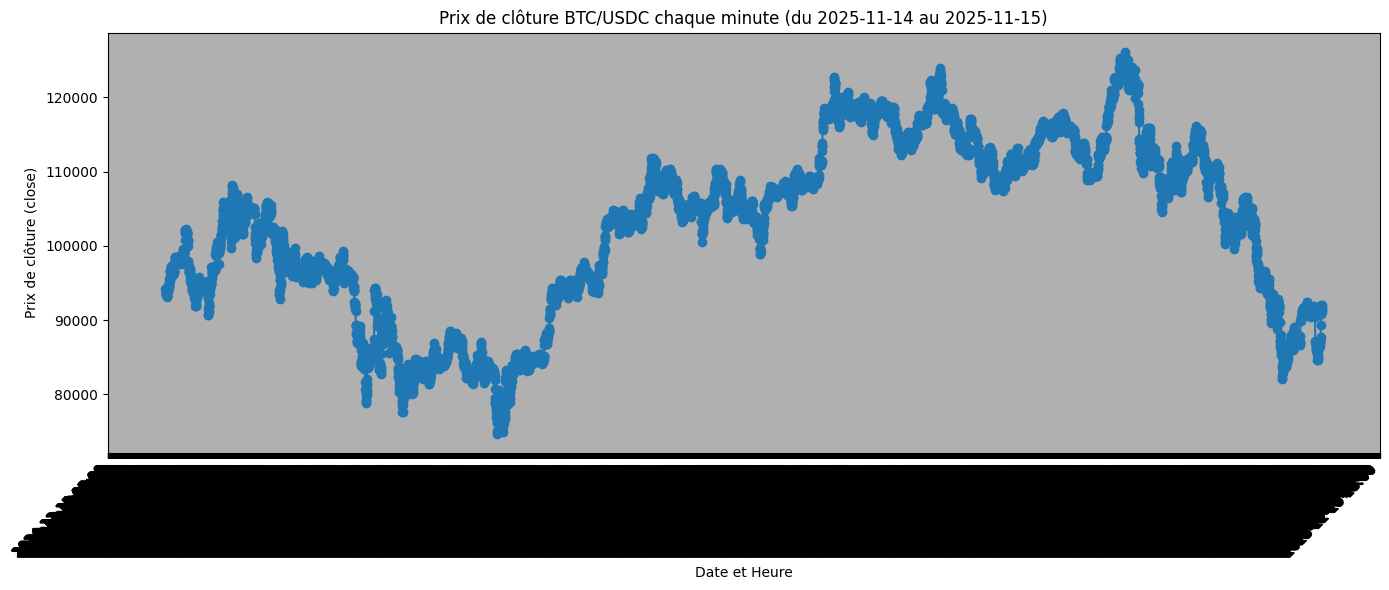

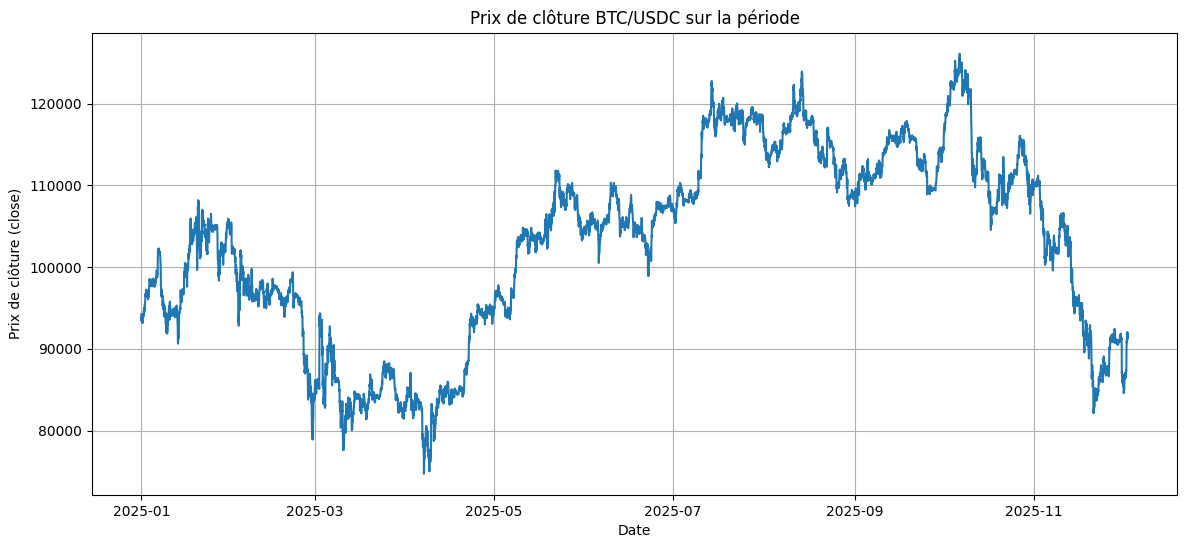

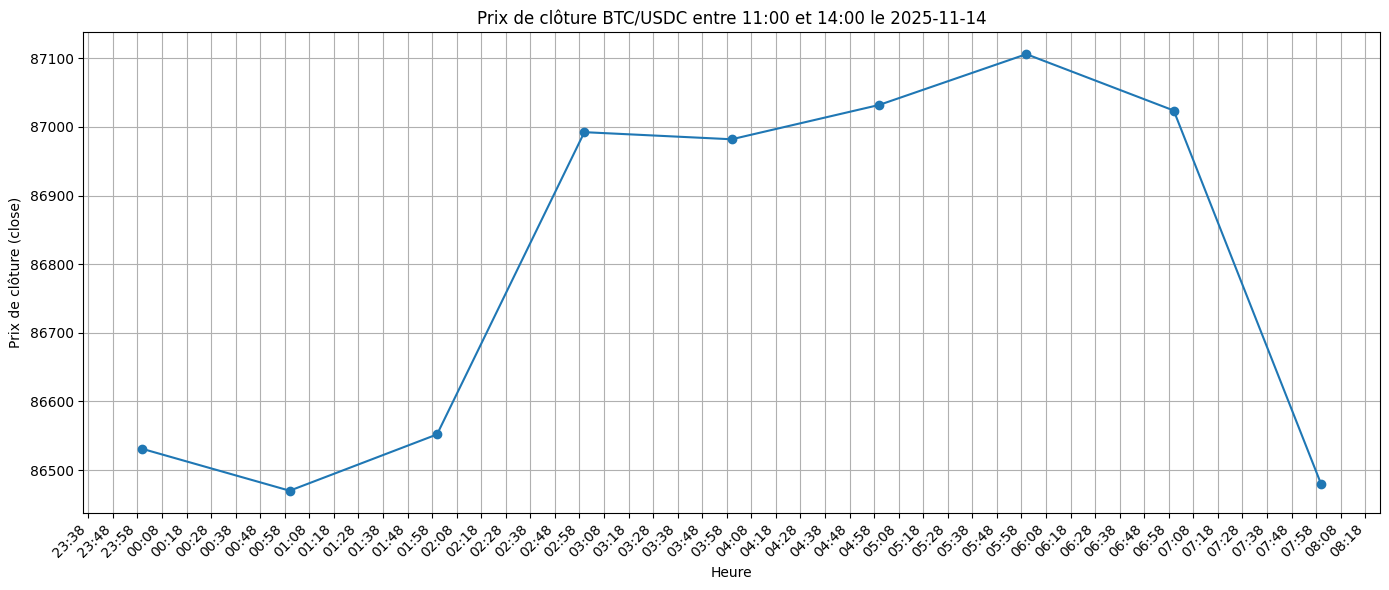

In [16]:
# Afficher un graphique de la colonne 'close' en fonction de la colonne 'open_time' (dates toutes les heures en abscisse)
import matplotlib.pyplot as plt

# Vérifier que la colonne 'open_time' est bien de type datetime
if not pd.api.types.is_datetime64_any_dtype(df_debug['open_time']):
    df_debug['open_time'] = pd.to_datetime(df_debug['open_time'])

plt.figure(figsize=(14, 6))
plt.plot(df_debug['open_time'], df_debug['close'], marker='o', linestyle='-')
plt.title("Prix de clôture BTC/USDC chaque minute (du 2025-11-14 au 2025-11-15)")
plt.xlabel("Date et Heure")
plt.ylabel("Prix de clôture (close)")
plt.grid(True)

# Formater les dates sur l'axe x toutes les heures pour lisibilité
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.gcf().autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Vérifier que la colonne 'open_time' est bien de type datetime
if not pd.api.types.is_datetime64_any_dtype(df_debug['open_time']):
    df_debug['open_time'] = pd.to_datetime(df_debug['open_time'])

plt.figure(figsize=(14, 6))
plt.plot(df_debug['open_time'], df_debug['close'])
plt.title("Prix de clôture BTC/USDC sur la période")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (close)")
plt.grid()
plt.show()

# Afficher un zoom sur la période entre 11:00 et 14:00 du 2025-11-14

# S'assurer que la colonne 'open_time' est bien de type datetime
if not pd.api.types.is_datetime64_any_dtype(df_debug['open_time']):
    df_debug['open_time'] = pd.to_datetime(df_debug['open_time'])

# Définir la période de zoom
start_zoom = pd.Timestamp('2025-12-02 00:00:00')
end_zoom = pd.Timestamp('2025-12-02 08:00:00')

mask_zoom = (df_debug['open_time'] >= start_zoom) & (df_debug['open_time'] <= end_zoom)
df_zoom = df_debug[mask_zoom]

plt.figure(figsize=(14, 6))
plt.plot(df_zoom['open_time'], df_zoom['close'], marker='o', linestyle='-')
plt.title("Prix de clôture BTC/USDC entre 11:00 et 14:00 le 2025-11-14")
plt.xlabel("Heure")
plt.ylabel("Prix de clôture (close)")
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.gcf().autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()




In [17]:
#df =pd.read_csv("data_BTC-USD.csv")
#df.columns = ['open_time','symbol','open', 'high', 'low', 'close', 'volume']
#df.drop(columns=['symbol'], inplace=True)

df = pd.read_csv("data_BTC-USDC_1h_2021-01-01_2025-12-10.csv")
df.columns = ['open_time','open', 'high', 'low', 'close', 'volume']
df.dropna(inplace=True)
df.head()

,open_time,open,high,low,close,volume
0,2021-01-01 00:00:00,28964.540000,29085.890000,28741.860000,29035.040000,74.627125
1,2021-01-01 01:00:00,29052.990000,29522.680000,29005.840000,29463.010000,155.313197
2,2021-01-01 02:00:00,29470.030000,29510.130000,29179.000000,29249.200000,66.196418
3,2021-01-01 03:00:00,29254.850000,29400.000000,29205.940000,29331.570000,62.622316
4,2021-01-01 04:00:00,29350.350000,29441.470000,29116.090000,29271.610000,68.044040


## Étape 2 : Calcul des indicateurs techniques

Nous définissons une fonction `compute_indicators` pour calculer :
- Les retours simples sur 1, 4, 12 et 24 bougies.
- Les moyennes mobiles simples (SMA) et exponentielles (EMA) sur 10, 20 et 50 périodes.
- Les différences SMA20‑SMA50 et EMA20‑EMA50.
- Le RSI sur 14 périodes.
- L'Average True Range (ATR) et son ratio par rapport au prix de clôture.
- L'Average Directional Index (ADX).
- Les composantes du MACD (ligne MACD, signal et histogramme).

Une fois les indicateurs calculés, on supprime les lignes contenant des valeurs manquantes.

In [18]:
# Fonction pour calculer les indicateurs techniques
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    # Retours simples
    for lag in [1, 4, 12, 24]:
        data[f'return_{lag}'] = data['close'].pct_change(lag)
    # SMA et EMA
    for window in [10, 20, 50]:
        data[f'sma_{window}'] = data['close'].rolling(window).mean()
        data[f'ema_{window}'] = data['close'].ewm(span=window, adjust=False).mean()
    # Différences MA20‑MA50
    data['sma_20_50_diff'] = data['sma_20'] - data['sma_50']
    data['ema_20_50_diff'] = data['ema_20'] - data['ema_50']
    # RSI 14
    delta = data['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain, index=data.index).rolling(14).mean()
    roll_down = pd.Series(loss, index=data.index).rolling(14).mean()
    rs = roll_up / roll_down
    data['rsi_14'] = 100.0 - (100.0 / (1.0 + rs))
    # ATR et ATR relatif
    high = data['high']
    low = data['low']
    close_ = data['close']
    prev_close = close_.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    data['atr_14'] = tr.rolling(14).mean()
    data['atr_rel_14'] = data['atr_14'] / data['close']
    # ADX
    up_move = high.diff()
    down_move = -low.diff()
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    atr_mean = tr.rolling(14).mean()
    plus_di = 100 * pd.Series(plus_dm, index=data.index).rolling(14).mean() / atr_mean
    minus_di = 100 * pd.Series(minus_dm, index=data.index).rolling(14).mean() / atr_mean
    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    data['adx_14'] = dx.rolling(14).mean()
    # MACD
    ema_12 = data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['close'].ewm(span=26, adjust=False).mean()
    data['macd'] = ema_12 - ema_26
    data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
    data['macd_hist'] = data['macd'] - data['macd_signal']
    return data

# Calcul des indicateurs
df_features = compute_indicators(df)
df_features = df_features.dropna().reset_index(drop=True)
print(f'Données avec indicateurs: {df_features.shape[0]} lignes, {df_features.shape[1]} colonnes')
df_features.head()

Données avec indicateurs: 39295 lignes, 25 colonnes


,open_time,open,high,low,close,volume,return_1,return_4,return_12,return_24,...,ema_50,sma_20_50_diff,ema_20_50_diff,rsi_14,atr_14,atr_rel_14,adx_14,macd,macd_signal,macd_hist
0,2021-01-03 01:00:00,32487.570000,32816.730000,32258.540000,32597.080000,74.686615,0.003371,0.028113,0.031553,0.106726,...,30531.974481,1242.209500,982.968884,66.912604,1000.264286,0.030686,55.916354,727.870273,693.173013,34.697261
1,2021-01-03 02:00:00,32600.000000,32910.330000,32599.180000,32784.030000,51.071032,0.005735,0.018503,0.047413,0.115144,...,30620.290384,1316.062200,1015.518375,64.131616,940.814286,0.028697,53.676471,739.356323,702.409675,36.946648
2,2021-01-03 03:00:00,32780.370000,32785.380000,32484.330000,32609.890000,74.186637,-0.005312,0.012252,0.026502,0.108326,...,30698.313898,1392.376600,1030.264503,57.443669,888.676429,0.027252,49.813153,726.038141,707.135368,18.902773
3,2021-01-03 04:00:00,32630.130000,33276.230000,32500.000000,33233.250000,72.167978,0.019116,0.022953,0.021073,0.128858,...,30797.723157,1479.799600,1074.157301,63.601199,902.466429,0.027156,45.132243,757.056453,717.119585,39.936868
4,2021-01-03 05:00:00,33221.260000,34222.400000,33153.980000,33767.570000,238.955259,0.016078,0.035908,0.025260,0.137783,...,30914.187739,1596.429100,1138.234580,63.937925,937.553571,0.027765,41.072556,815.354943,736.766657,78.588286


## Étape 3 : Définition de la cible

Nous voulons prédire s'il est intéressant d'acheter du BTC à un instant donné pour un horizon fixe de 24 heures (soit 96 bougies de 15 minutes).

Pour chaque timestamp t, on calcule le ROI futur comme : (close_{t+H} - close_t) / close_t.

On considère qu'un aller-retour (achat + vente) coûte 0,2 % (0,1 % par ordre). La cible binaire est donc :
- **1 (Acheter)** si le ROI futur est supérieur ou égal à 0,002 ;
- **0 (Ne pas acheter)** sinon.

On ajoute cette colonne `target` et on supprime les dernières lignes sans horizon futur.

In [19]:
# Paramètres de la cible
horizon = 96  # nombre de bougies de 15m pour 24h
FEE_ROUNDTRIP = 0.002  # 0,2 % de frais
fee_threshold = FEE_ROUNDTRIP

df_feat = df_features.copy()
df_feat['roi_future'] = (df_feat['close'].shift(-horizon) - df_feat['close']) / df_feat['close']
df_feat['target'] = (df_feat['roi_future'] >= fee_threshold).astype(int)
# Retirer les dernières lignes où le ROI futur n'est pas défini
df_feat = df_feat.iloc[:-horizon].reset_index(drop=True)
df_feat[['roi_future', 'target']].head()

,roi_future,target
0,0.133819,1
1,0.130359,1
2,0.152227,1
3,0.130643,1
4,0.110331,1


In [20]:
df_feat['target'].value_counts(normalize=True)

target
0   0.501441
1   0.498559
Name: proportion, dtype: float64

## Étape 4 : Split chronologique

Nous séparons les données en trois ensembles de manière chronologique (sans permuter les lignes) :
- **Train** : 70 % des premières observations.
- **Validation** : 15 % suivantes.
- **Test** : 15 % finales.

Cela évite le leakage temporel entre l'entraînement et l'évaluation.

In [23]:
df_feat

,open_time,open,high,low,close,volume,return_1,return_4,return_12,return_24,...,ema_20_50_diff,rsi_14,atr_14,atr_rel_14,adx_14,macd,macd_signal,macd_hist,roi_future,target
0,2021-01-03 01:00:00,32487.570000,32816.730000,32258.540000,32597.080000,74.686615,0.003371,0.028113,0.031553,0.106726,...,982.968884,66.912604,1000.264286,0.030686,55.916354,727.870273,693.173013,34.697261,0.133819,1
1,2021-01-03 02:00:00,32600.000000,32910.330000,32599.180000,32784.030000,51.071032,0.005735,0.018503,0.047413,0.115144,...,1015.518375,64.131616,940.814286,0.028697,53.676471,739.356323,702.409675,36.946648,0.130359,1
2,2021-01-03 03:00:00,32780.370000,32785.380000,32484.330000,32609.890000,74.186637,-0.005312,0.012252,0.026502,0.108326,...,1030.264503,57.443669,888.676429,0.027252,49.813153,726.038141,707.135368,18.902773,0.152227,1
3,2021-01-03 04:00:00,32630.130000,33276.230000,32500.000000,33233.250000,72.167978,0.019116,0.022953,0.021073,0.128858,...,1074.157301,63.601199,902.466429,0.027156,45.132243,757.056453,717.119585,39.936868,0.130643,1
4,2021-01-03 05:00:00,33221.260000,34222.400000,33153.980000,33767.570000,238.955259,0.016078,0.035908,0.025260,0.137783,...,1138.234580,63.937925,937.553571,0.027765,41.072556,815.354943,736.766657,78.588286,0.110331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39194,2025-12-05 20:00:00,89666.510000,89783.720000,89224.050000,89341.730000,140.544020,-0.003622,0.005622,-0.030366,-0.034293,...,-734.293730,26.009670,857.820714,0.009602,48.521184,-830.104713,-645.002722,-185.101990,0.042469,1
39195,2025-12-05 21:00:00,89338.900000,89518.410000,89100.520000,89208.920000,99.968240,-0.001487,-0.001871,-0.021446,-0.032311,...,-788.168381,25.539148,866.376429,0.009712,51.771781,-842.788907,-684.559959,-158.228948,0.038775,1
39196,2025-12-05 22:00:00,89211.660000,89397.650000,88937.100000,89269.200000,119.388300,0.000676,0.003264,-0.022414,-0.033622,...,-828.679889,26.897433,872.713571,0.009776,54.289215,-838.313574,-715.310682,-123.002891,0.040601,1
39197,2025-12-05 23:00:00,89271.210000,89410.000000,88962.320000,89358.000000,66.424710,0.000995,-0.003441,-0.022082,-0.029847,...,-855.826010,33.043909,824.438571,0.009226,56.587984,-818.170066,-735.882559,-82.287507,0.037423,1


In [25]:
# Split temporel
n = len(df_feat)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = df_feat.iloc[:train_end]
val_df = df_feat.iloc[train_end:val_end]
test_df = df_feat.iloc[val_end:]

print(f"Train : {train_df['open_time'].iloc[0]} → {train_df['open_time'].iloc[-1]}")
print(f"Validation : {val_df['open_time'].iloc[0]} → {val_df['open_time'].iloc[-1]}")
print(f"Test : {test_df['open_time'].iloc[0]} → {test_df['open_time'].iloc[-1]}")

# Définir les colonnes de features en excluant l'horodatage, le ROI futur et la cible
feature_cols = [c for c in df_feat.columns if c not in ['open_time', 'roi_future', 'target']]

X_train, y_train = train_df[feature_cols], train_df['target']
X_val, y_val = val_df[feature_cols], val_df['target']
X_test, y_test = test_df[feature_cols], test_df['target']

Train : 2021-01-03 01:00:00 → 2024-08-03 00:00:00
Validation : 2024-08-03 01:00:00 → 2025-04-05 00:00:00
Test : 2025-04-05 01:00:00 → 2025-12-06 00:00:00


## Étape 5 : Modèle RandomForest (baseline)

Nous optimisons les hyperparamètres du **RandomForestClassifier** avec un **GridSearchCV** utilisant **TimeSeriesSplit** (pour respecter l'ordre chronologique des données).

Les hyperparamètres optimisés sont :
- **max_depth** : [5, 8, 10, 15, 20, None]
- **class_weight** : ['balanced', 'balanced_subsample', None]

Le modèle est entraîné sur les données d'**entraînement** et évalué sur les données de **validation**. Le seuil par défaut de 0,5 est utilisé pour convertir les probabilités en classes.

Nous calculons l'accuracy, la précision, le rappel, le F1-score, l'AUC et la matrice de confusion sur l'ensemble de validation.

In [ ]:
# GridSearchCV pour optimiser max_depth et class_weight du RandomForest
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Définir la grille des hyperparamètres à tester
param_grid = {
    'max_depth': [5, 8, 10, 15, 20, None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Créer le modèle de base
rf_base = RandomForestClassifier(n_estimators=200, random_state=42)

# TimeSeriesSplit pour respecter l'ordre chronologique des données
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV avec TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=tscv,  # Time Series Cross-Validation
    scoring='roc_auc',  # Optimiser pour l'AUC
    n_jobs=-1,  # Utiliser tous les CPU disponibles
    verbose=2
)

print("Début du GridSearchCV sur les données d'entraînement...")
grid_search.fit(X_train, y_train)

print("\n=== Résultats du GridSearchCV ===")
print(f"Meilleurs paramètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score AUC (CV) : {grid_search.best_score_:.4f}")

# Afficher les 5 meilleures combinaisons
import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("\nTop 5 des meilleures combinaisons :")
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

Début du GridSearchCV sur les données d'entraînement...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .................class_weight=balanced, max_depth=5; total time=   1.2s
[CV] END .................class_weight=balanced, max_depth=8; total time=   1.6s
[CV] END ................class_weight=balanced, max_depth=10; total time=   1.8s
[CV] END .................class_weight=balanced, max_depth=5; total time=   2.4s
[CV] END .................class_weight=balanced, max_depth=8; total time=   3.5s
[CV] END .................class_weight=balanced, max_depth=5; total time=   3.8s
[CV] END ................class_weight=balanced, max_depth=15; total time=   2.3s
[CV] END ................class_weight=balanced, max_depth=10; total time=   4.1s
[CV] END .................class_weight=balanced, max_depth=5; total time=   5.1s
[CV] END .................class_weight=balanced, max_depth=8; total time=   5.5s
[CV] END ................class_weight=balanced, max_depth=20; total time=

In [26]:
# Entraînement du RandomForest avec les meilleurs paramètres du GridSearchCV
rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=grid_search.best_params_['max_depth'],
    class_weight=grid_search.best_params_['class_weight'],
    random_state=42
)
print(f"\nMeilleurs paramètres trouvés :")
print(f"  - max_depth : {grid_search.best_params_['max_depth']}")
print(f"  - class_weight : {grid_search.best_params_['class_weight']}")

rf.fit(X_train, y_train)

# Prédictions et métriques sur l'ensemble de VALIDATION
probs_val_rf = rf.predict_proba(X_val)[:, 1]
threshold_rf = 0.5
preds_val_rf = (probs_val_rf >= threshold_rf).astype(int)

acc_rf = accuracy_score(y_val, preds_val_rf)
prec_rf = precision_score(y_val, preds_val_rf)
rec_rf = recall_score(y_val, preds_val_rf)
f1_rf = f1_score(y_val, preds_val_rf)
auc_rf = roc_auc_score(y_val, probs_val_rf)
cm_rf = confusion_matrix(y_val, preds_val_rf)

print('\nPerformances RandomForest sur VALIDATION (seuil = 0,5):')
print(f'Accuracy : {acc_rf:.3f}')
print(f'Precision : {prec_rf:.3f}')
print(f'Recall    : {rec_rf:.3f}')
print(f'F1-score : {f1_rf:.3f}')
print(f'AUC      : {auc_rf:.3f}')
print('Matrice de confusion :')
print(cm_rf)

# Prédictions sur TEST pour les analyses ultérieures (PnL, etc.)
probs_test_rf = rf.predict_proba(X_test)[:, 1]
preds_test_rf = (probs_test_rf >= threshold_rf).astype(int)

NameError: name 'grid_search' is not defined

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

token = os.getenv("HF_TOKEN")
if token is None:
    raise RuntimeError("HF_TOKEN non trouvé dans les variables d'environnement. Ajoutez-le dans votre .env.")
!hf auth login --token "$token"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `P09 write` has been saved to /Users/nicolaspages/.cache/huggingface/stored_tokens
Your token has been saved to /Users/nicolaspages/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


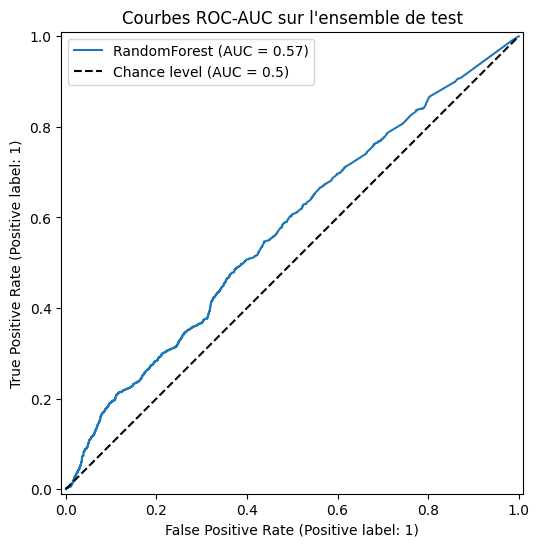

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Créer une figure et des axes pour le plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC pour RandomForest
roc_display_rf = RocCurveDisplay.from_predictions(
    y_val, probs_val_rf, name="RandomForest", ax=ax, plot_chance_level=True
)

# Ajouter un titre et afficher la légende
ax.set_title("Courbes ROC-AUC sur l'ensemble de test")
ax.legend()
plt.show()

In [15]:
import pandas as pd

# Créer un dictionnaire pour stocker les métriques
metrics_data = {
    'Model': ['RandomForest'],
    'Accuracy': [acc_rf],
    'Precision': [prec_rf],
    'Recall': [rec_rf],
    'F1-Score': [f1_rf],
    'AUC': [auc_rf]
}

# Créer un DataFrame
comparison_df = pd.DataFrame(metrics_data)

# Afficher le tableau de comparaison
print("\nTableau de comparaison des modèles:")
print(comparison_df.round(3))



Tableau de comparaison des modèles:
          Model  Accuracy  Precision   Recall  F1-Score      AUC
0  RandomForest  0.525000   0.680000 0.209000  0.320000 0.572000


In [6]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class CryptoTradingEnv(gym.Env):
    """
    Env très simple :
    - Observation : vecteur de features à l'instant t
    - Action : 0 = ne rien faire, 1 = prendre un trade long sur l'horizon défini
    - Reward : roi_future - frais si action=1, sinon 0
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, df, feature_cols, fee_per_roundtrip=0.002):
        super(CryptoTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.feature_cols = feature_cols
        self.fee_per_roundtrip = fee_per_roundtrip

        # Pré-calcul des arrays numpy
        self.obs_array = self.df[self.feature_cols].values.astype(np.float32)
        self.roi_array = self.df["roi_future"].values.astype(np.float32)

        self.n_steps = len(self.df)
        self.current_step = 0

        # Espace des actions : 0 (pas de trade) ou 1 (trade long)
        self.action_space = spaces.Discrete(2)

        # Observation = vecteur de features
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(self.feature_cols),),
            dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        obs = self.obs_array[self.current_step]
        return obs

    def step(self, action):
        """
        action : 0 ou 1
        reward = roi_future - fees si action=1, sinon 0
        """
        roi = self.roi_array[self.current_step]

        if action == 1:
            reward = roi - self.fee_per_roundtrip
        else:
            reward = 0.0

        self.current_step += 1
        done = self.current_step >= (self.n_steps - 1)

        obs = self.obs_array[self.current_step] if not done else self.obs_array[-1]

        info = {}
        return obs, float(reward), done, info

    def render(self, mode="human"):
        pass


# On suppose que train_df, val_df, test_df et feature_cols sont déjà définis (c’est le cas dans ton notebook)
train_env = DummyVecEnv([
    lambda: CryptoTradingEnv(train_df, feature_cols, fee_per_roundtrip=0.002)
])

# Optionnel : on pourrait aussi faire un env sur train+val en concaténant


ModuleNotFoundError: No module named 'gym'

In [7]:
# ==============================
# Entraînement PPO sur train_env
# ==============================
ppo_model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    tensorboard_log=None,   # tu peux mettre un chemin si tu veux suivre les logs
)

# À ajuster : plus de timesteps = meilleur entraînement mais plus long
ppo_model.learn(total_timesteps=100_000)

# ==============================================
# Génération des actions RL sur la période de test
# ==============================================
# Ici on ne passe pas par un env pour le test, on applique directement le policy
# sur chaque observation, car l'état est simplement "le vecteur de features courant".

X_test_array = test_df[feature_cols].values.astype(np.float32)

rl_actions = []
for i in range(len(X_test_array)):
    obs = X_test_array[i]
    action, _ = ppo_model.predict(obs, deterministic=True)
    rl_actions.append(int(action))

rl_actions = np.array(rl_actions)

print("Aperçu des actions RL (0=pas de trade, 1=trade long) :")
print(rl_actions[:30])

# Cette variable rl_actions sera automatiquement récupérée
# par la cellule PnL que je t’ai donnée précédemment.


NameError: name 'PPO' is not defined

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_pnl_horizon(
    roi_future,
    actions,
    horizon,
    fee_open=0.00075,   # 0.1 % à l'entrée
    fee_close=0.00075,  # 0.1 % à la sortie (total 0.2 %, cohérent avec fee_threshold)
    initial_capital=1_000.0,
    all_in=False,
    position_fraction=0.1,
):
    """
    Backtest non-chevauchant, cohérent avec la définition de roi_future :

    - A l'instant t :
        * si action[t] == 1 : on entre en position et on la tient jusqu'à t + horizon
        * si action[t] == 0 : on ne fait rien, on passe à t+1
    - Le ROI brut utilisé est roi_future[t] = (close[t+h] - close[t]) / close[t]
    - Les frais sont appliqués à l'entrée ET à la sortie.

    Paramètres
    ----------
    roi_future : array-like
        Série des ROI futurs (df_feat['roi_future']) sur la période de test.
    actions : array-like
        Série d'actions 0/1 (prédictions modèle) alignée avec roi_future.
        1 = on prend un trade (on se met long pour la fenêtre de 24h).
    horizon : int
        Fenêtre fixe en nombre de bougies (ici 96 pour 24h).
    fee_open : float
        Frais proportionnel à l'entrée (ex: 0.001 = 0.1 %).
    fee_close : float
        Frais proportionnel à la sortie (ex: 0.001 = 0.1 %).
    initial_capital : float
        Capital de départ.
    all_in : bool
        Si True : on investit 100 % du capital sur chaque trade.
        Si False : on investit seulement une fraction (position_fraction).
    position_fraction : float
        Fraction du capital investie par trade si all_in=False.

    Retour
    ------
    dict avec :
        - equity_curve : np.array, capital au fil du temps
        - final_capital, total_return_%
        - nb_trades, hit_ratio_%, avg_trade_return_%
    """

    roi_future = np.asarray(roi_future, dtype=float)
    actions = np.asarray(actions, dtype=int)
    n = len(roi_future)

    assert roi_future.shape[0] == actions.shape[0], "Longueurs incohérentes roi_future / actions"

    equity = initial_capital
    equity_curve = []
    trade_rois_net = []  # ROI net par trade
    trade_indices = []   # index t où le trade est ouvert

    i = 0
    while i < n - horizon:
        if actions[i] == 1:
            # ROI brut sur la fenêtre [i, i+horizon]
            gross_roi = roi_future[i]

            # Application des frais :
            # - à l'entrée: on paie fee_open sur le notional
            # - à la sortie: on paie fee_close sur le notional (après variation de prix)
            # Facteur total :
            # capital_final = capital_initial * (1 - fee_open) * (1 + gross_roi) * (1 - fee_close)
            factor_net = (1 - fee_open) * (1 + gross_roi) * (1 - fee_close)
            roi_net = factor_net - 1.0

            if all_in:
                # On investit 100 % du capital sur ce trade
                equity = equity * (1.0 + roi_net)
            else:
                # On n'investit qu'une fraction du capital
                invested = equity * position_fraction
                pnl = invested * roi_net
                equity = equity + pnl

            trade_rois_net.append(roi_net)
            trade_indices.append(i)

            # On "bloque" le capital pendant toute la fenêtre : même equity pendant horizon pas
            for _ in range(horizon):
                equity_curve.append(equity)

            # On saute directement au bout de la fenêtre
            i += horizon
        else:
            # Pas de trade : le capital ne bouge pas, on avance d'une bougie
            equity_curve.append(equity)
            i += 1

    # On étend la courbe jusqu'à la fin des données si besoin
    while len(equity_curve) < n:
        equity_curve.append(equity)

    equity_curve = np.array(equity_curve)

    trade_rois_net = np.array(trade_rois_net)
    nb_trades = len(trade_rois_net)
    if nb_trades > 0:
        hit_ratio = (trade_rois_net > 0).mean() * 100
        avg_trade_return = trade_rois_net.mean() * 100
    else:
        hit_ratio = np.nan
        avg_trade_return = np.nan

    result = {
        "initial_capital": float(initial_capital),
        "final_capital": float(equity),
        "total_return_%": float((equity / initial_capital - 1.0) * 100),
        "nb_trades": int(nb_trades),
        "hit_ratio_%": float(hit_ratio),
        "avg_trade_return_%": float(avg_trade_return),
        "equity_curve": equity_curve,
        "trade_indices": trade_indices,
        "trade_rois_net": trade_rois_net,
    }

    return result


In [ ]:
class Trader:
    def __init__(self, row: pd.Series, idx: int, idx_entry: int, signal: np.ndarray, capital: float, portfolio: float, position: float, qty: float, entry_price: float, exit_price: float, fee_roundtrip=0.002, pct_capital=1, debug=False, trade_list=[]):
        self.row = row
        self.idx = idx
        self.signal = signal
        self.fee_roundtrip = fee_roundtrip
        self.pct_capital = pct_capital
        self.capital = capital    
        self.portfolio = portfolio
        self.position = position
        self.qty = qty
        self.entry_price = entry_price
        self.exit_price = exit_price
        self.debug = debug
        self.idx_entry = idx_entry
        self.trade_list = trade_list
        self.timestamp_entry = None
        self.max_drawdown_pct = 0


    def _buy(self):
        self.qty = self.pct_capital * self.capital / self.row["Close"]
        position_value = self.qty * self.row["Close"]
        self.position = position_value  # Montant investi dans la position
        self.entry_price = self.row["Close"]
        buy_fees = self.fee_roundtrip * position_value / 2
        self.capital -= (position_value + buy_fees)
        self.portfolio = position_value  # Portfolio = valeur de la position
        self.idx_entry = self.idx
        self.timestamp_entry = self.row["Timestamp"]
        if self.debug:
            print(f"Idx: {self.idx} / Buy: {self.qty:.8f} @ {self.entry_price:.2f}")
        return True

    def _sell(self):
        sell_value = self.qty * self.row["Close"]
        sell_fees = self.fee_roundtrip * sell_value / 2
        PnL = self.qty * (self.row["Close"] - self.entry_price)
        PnL_net = PnL - sell_fees
        capital_before_sell = self.portfolio+self.capital
        self.capital += sell_value - sell_fees
        self.position = 0  # Plus de position ouverte
        self.exit_price = self.row["Close"]
        self.portfolio = 0  # Portfolio vide après vente
        self.max_drawdown_pct = (PnL/capital_before_sell)*100
        self.trade_list.append({
            "idx": self.idx,
            "idx_entry": self.idx_entry,
            "Timestamp": self.row["Timestamp"],
            "Timestamp_entry": self.timestamp_entry,
            "qty": self.qty,
            "entry_price": self.entry_price,
            "exit_price": self.exit_price,
            "PnL": PnL,
            "PnL_net": PnL_net,
            "Capital": self.capital,
            "MaxDrawDown": self.max_drawdown_pct,
        })

        if self.debug:
            print(f"Idx: {self.idx} / Sell: {self.qty:.8f} @ {self.exit_price:.2f}")
            print(f"PnL: {PnL:.2f}")
            print(f"PnL net (après frais): {PnL_net:.2f}")
            print(f"Portfolio: {self.portfolio:.2f}")
            print(f"Capital: {self.capital:.2f}")
        return True

    def run(self):
        # Conversion du signal en int (gère les cas numpy array et scalar)
        sig = int(self.signal) if isinstance(self.signal, (np.ndarray, np.generic)) else int(self.signal)
        
        # Mise à jour du portfolio si position ouverte (valeur actuelle de la position)
        if self.position > 0:
            self.portfolio = self.qty * self.row["Close"]
        
        if self.debug:
            print(f"Idx: {self.idx} / Signal: {sig} / Position: {self.position:.2f} / Portfolio: {self.portfolio:.2f}")
        
        # Achat : signal=1 et pas de position ouverte
        if sig == 1 and self.position == 0:
            self._buy()
        # Vente : signal=0 et position ouverte (on vend dès que le signal passe à 0)
        elif sig == 0 and self.position > 0 and self.idx >= self.idx_entry + HORIZON_STEPS:
            self._sell()
        
        return self.portfolio, self.capital, self.position, self.qty, self.entry_price, self.exit_price, self.trade_list     


class Backtest:
    def __init__(self, df_bt: pd.DataFrame, signal: np.ndarray, fee_roundtrip=0.002, pct_capital=1, capital_init=1000, debug=False):
        self.df_bt = df_bt
        self.signal = signal
        self.fee_roundtrip = fee_roundtrip
        self.pct_capital = pct_capital
        self.capital_init = capital_init  # Sauvegarder le capital initial
        self.capital = capital_init
        self.position = 0
        self.qty = 0
        self.entry_price = 0
        self.exit_price = 0
        self.portfolio = 0
        self.debug = debug
        self.idx_entry = 0
        self.trade_list = []
        self.max_drawdown_pct = 0
        self.run()
        self.print_stats()

    def run(self):
        trader = Trader([], 0, 0, 0, self.capital, self.portfolio, self.position, self.qty, self.entry_price, self.exit_price, self.fee_roundtrip, self.pct_capital, debug=self.debug, trade_list=self.trade_list)
        last_idx = None
        for i, row in self.df_bt.iterrows():
            trader.row = row
            trader.idx = i
            trader.signal = self.signal[i]
            trader.run()
            self.portfolio = trader.portfolio
            self.capital = trader.capital   
            self.position = trader.position
            self.qty = trader.qty
            self.entry_price = trader.entry_price
            self.exit_price = trader.exit_price
            self.idx_entry = trader.idx_entry
            self.timestamp_entry = trader.timestamp_entry
            last_idx = i

        # Clôture forcée si position ouverte en fin de backtest
        if self.position > 0 and last_idx is not None:
            last_row = self.df_bt.iloc[last_idx]
            sell_value = self.qty * last_row["Close"]
            sell_fees = self.fee_roundtrip * sell_value / 2
            PnL = self.qty * (last_row["Close"] - self.entry_price)
            PnL_net = PnL - sell_fees
            self.capital += sell_value - sell_fees
            self.portfolio = 0
            self.position = 0
            self.trade_list.append({
                "idx": last_idx,
                "idx_entry": self.idx_entry,
                "Timestamp": last_row["Timestamp"],
                "Timestamp_entry": self.timestamp_entry,
                "qty": self.qty,
                "entry_price": self.entry_price,
                "exit_price": last_row["Close"],
                "PnL": PnL,
                "PnL_net": PnL_net,
                "Capital": self.capital,
                "MaxDrawDown": self.max_drawdown_pct,
            })
            self.qty = 0
            self.entry_price = 0
            self.exit_price = 0
        
        days = (self.df_bt.iloc[-1]["Timestamp"] - self.df_bt.iloc[0]["Timestamp"]).days
        if days <= 0:
            days = 1  # Avoid division by zero
        self.days = days
        self.PnL = self.capital - self.capital_init
        self.ROI_pct = self.PnL / self.capital_init *100
        self.ROI_day_pct = self.PnL / self.capital_init / days * 100
        # Calculate annualized ROI: convert ROI_pct from percentage to decimal first
        roi_decimal = self.ROI_pct / 100
        if roi_decimal <= -1:
            # If we lost more than 100%, return -100%
            self.ROI_annualized_pct = -100.0
        else:
            self.ROI_annualized_pct = ((1 + roi_decimal) ** (365.0 / days) - 1) * 100
        self.df_trades = pd.DataFrame(self.trade_list)
        self.win_rates = self.df_trades["PnL"].apply(lambda x: x > 0).mean()*100
        self.nb_trades = len(self.df_trades)
        self.nb_trades_by_day = self.nb_trades / days
        self.max_drawdown_pct = self.df_trades["MaxDrawDown"].max()
        return self.portfolio, self.capital, self.position, self.qty, self.entry_price, self.exit_price, self.trade_list
    
    def print_stats(self):
        print(f"Days: {self.days}")
        print(f"Portfolio: {self.portfolio}")
        print(f"Capital: {self.capital}")
        print(f"PnL: {self.capital - CAPITAL_INIT}")
        print(f"Position: {self.position}")
        print(f"ROI: {self.ROI_pct:.2f}%")
        print(f"ROI annualized: {self.ROI_annualized_pct:.2f}%")
        print(f"ROI day: {self.ROI_day_pct:.2f}%")
        print(f"Win rate: {self.win_rates:.2f}%")
        print(f"Nb trades: {self.nb_trades}")
        print(f"Nb trades par jour: {self.nb_trades_by_day:.2f}")
        print(f"Max DrawDown: {self.max_drawdown_pct:.2f}%")


In [ ]:
backtester = Backtest(test_df.reset_index(), preds_val_rf, fee_roundtrip=0, pct_capital=1, capital_init=CAPITAL_INIT, debug=False)


=== Stratégie RandomForest ===
Capital initial             : 1000.00
Capital final               : 1044.60
Rendement total (%)         : 4.46
Nombre de trades            : 17
Taux de trades gagnants (%) : 52.94
Gain moyen par trade (%)    : 1.3069

=== Stratégie RL (PPO) ===
Capital initial             : 1000.00
Capital final               : 1009.97
Rendement total (%)         : 1.00
Nombre de trades            : 61
Taux de trades gagnants (%) : 50.82
Gain moyen par trade (%)    : 0.0999

Résumé PnL stratégies :


,Stratégie,Capital final,Rendement total (%),Nb trades
0,RandomForest,1044.599840,4.459984,17
1,RL (PPO),1009.970185,0.997019,61


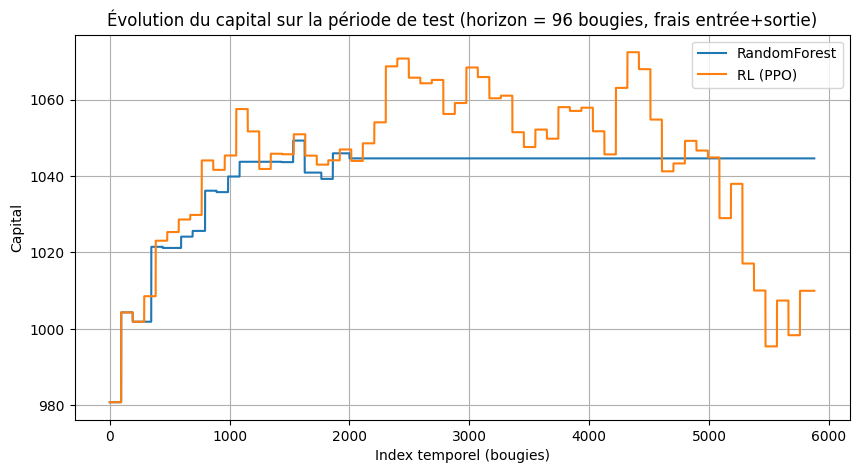

In [19]:
# Série des ROI futurs sur la période de test
test_roi = test_df["roi_future"].reset_index(drop=True)

# Actions des modèles, alignées avec test_roi
rf_actions = pd.Series(preds_val_rf).reset_index(drop=True)
rl_actions = pd.Series(rl_actions).reset_index(drop=True)

# On s'aligne sur la même longueur, par sécurité
min_len = min(len(test_roi), len(rf_actions), len(rl_actions))
test_roi = test_roi.iloc[:min_len]
rf_actions = rf_actions.iloc[:min_len]
rl_actions = rl_actions.iloc[:min_len]

# On choisit les frais cohérents avec fee_threshold = 0.002 (0.2 % round-trip)
fee_roundtrip = 0.0015
fee_open = fee_roundtrip / 2  
fee_close = fee_roundtrip / 2 

# PnL RandomForest
rf_pnl = compute_pnl_horizon(
    roi_future=test_roi,
    actions=rf_actions,
    horizon=horizon,
    fee_open=fee_open,
    fee_close=fee_close,
    initial_capital=1_000.0,
    all_in=False,      
    position_fraction=0.2,
)

# PnL RL (PPO)
rl_pnl = compute_pnl_horizon(
    roi_future=test_roi,
    actions=rl_actions,
    horizon=horizon,
    fee_open=fee_open,
    fee_close=fee_close,
    initial_capital=1_000.0,
    all_in=False,      
    position_fraction=0.2,
)

print("=== Stratégie RandomForest ===")
print(f"Capital initial             : {rf_pnl['initial_capital']:.2f}")
print(f"Capital final               : {rf_pnl['final_capital']:.2f}")
print(f"Rendement total (%)         : {rf_pnl['total_return_%']:.2f}")
print(f"Nombre de trades            : {rf_pnl['nb_trades']}")
print(f"Taux de trades gagnants (%) : {rf_pnl['hit_ratio_%']:.2f}")
print(f"Gain moyen par trade (%)    : {rf_pnl['avg_trade_return_%']:.4f}")

print("\n=== Stratégie RL (PPO) ===")
print(f"Capital initial             : {rl_pnl['initial_capital']:.2f}")
print(f"Capital final               : {rl_pnl['final_capital']:.2f}")
print(f"Rendement total (%)         : {rl_pnl['total_return_%']:.2f}")
print(f"Nombre de trades            : {rl_pnl['nb_trades']}")
print(f"Taux de trades gagnants (%) : {rl_pnl['hit_ratio_%']:.2f}")
print(f"Gain moyen par trade (%)    : {rl_pnl['avg_trade_return_%']:.4f}")

# Résumé comparatif
summary = pd.DataFrame(
    [
        ["RandomForest", rf_pnl["final_capital"], rf_pnl["total_return_%"], rf_pnl["nb_trades"]],
        ["RL (PPO)",     rl_pnl["final_capital"], rl_pnl["total_return_%"], rl_pnl["nb_trades"]],
    ],
    columns=["Stratégie", "Capital final", "Rendement total (%)", "Nb trades"],
)

print("\nRésumé PnL stratégies :")
display(summary)

# Courbes d'equity
plt.figure(figsize=(10, 5))
plt.plot(rf_pnl["equity_curve"], label="RandomForest")
plt.plot(rl_pnl["equity_curve"], label="RL (PPO)")
plt.title(f"Évolution du capital sur la période de test (horizon = {horizon} bougies, frais entrée+sortie)")
plt.xlabel("Index temporel (bougies)")
plt.ylabel("Capital")
plt.grid(True)
plt.legend()
plt.show()
